# GradientBoosting and AdaBoost Models for Diabetes Prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV



## 1. Data Acquisition

In [2]:
df = pd.read_csv("../datasets/Processed_data.csv",sep=",",index_col="PatientID")
df.shape

(15298, 18)

## 2. Data Preparation

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
# Split data into training and testing sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [5]:
# Display training data shape
df_train.shape

(12238, 18)

In [6]:
# Define feature columns
feature_columns = ['Pregnancies', 'PlasmaGlucose', 'DiastolicBloodPressure',
                   'TricepsThickness', 'SerumInsulin', 'BMI', 'DiabetesPedigree', 'Age']

In [7]:
# Extract features and target for training data
X_train = df_train.loc[:, feature_columns].values
y_train = df_train.Diabetic.values

In [8]:
# Extract features and target for test data
X_test = df_test.loc[:, feature_columns].values
y_test = df_test.Diabetic.values

## 3. GradientBoosting and AdaBoost Models Implementation

In [9]:
models = {
    "GradientBoosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier()
}

# Dictionary to store results and predictions
results = {}
predictions = {}

# Train models and store predictions
for name, model in models.items():
    model.fit(X_train, y_train)  # Train model
    y_test_predicted = model.predict(X_test)  # Predict on test set

    # Store predictions
    predictions[name] = y_test_predicted

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_test_predicted)
    results[name] = accuracy

    print(f"{name} Accuracy = {accuracy:.2f}")

GradientBoosting Accuracy = 0.96
AdaBoost Accuracy = 0.95


## 4. Model Evaluation

### 4.1 Confusion Matrix

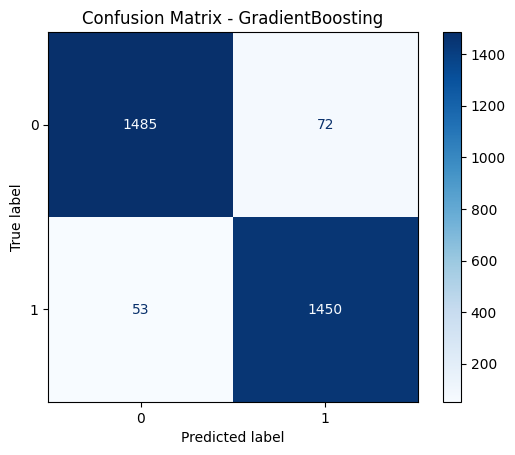

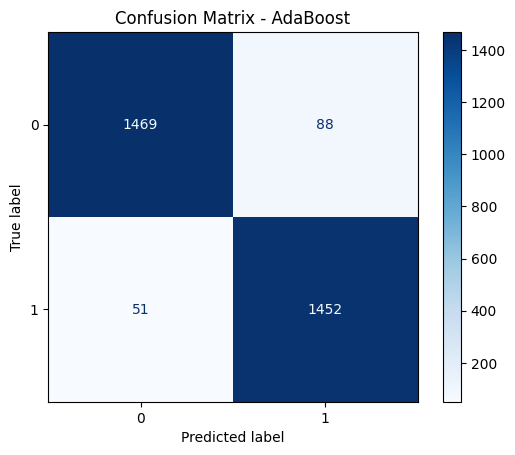

In [10]:
# Generate confusion matrices for each model
for name, y_pred in predictions.items():
    cm = confusion_matrix(y_test, y_pred)  # Compute confusion matrix

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")  # Use a blue colormap for better visibility
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


### 4.2 Classification Metrics

In [11]:
print("Precision, Recall, and Classification Report for Each Model\n")

# Calculate and display evaluation metrics for each model
for name, y_pred in predictions.items():
    precision = precision_score(y_test, y_pred, average='binary') 
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    
    # Classification report
    class_report = classification_report(y_test, y_pred)

    # Print results
    print(f"🔹 {name} Metrics:")
    print(f"   Precision: {precision:.2f}")
    print(f"   Recall: {recall:.2f}")
    print(f"   F1 Score: {f1:.2f}")
    print("   Classification Report:\n", class_report)


Precision, Recall, and Classification Report for Each Model

🔹 GradientBoosting Metrics:
   Precision: 0.95
   Recall: 0.96
   F1 Score: 0.96
   Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96      1557
           1       0.95      0.96      0.96      1503

    accuracy                           0.96      3060
   macro avg       0.96      0.96      0.96      3060
weighted avg       0.96      0.96      0.96      3060

🔹 AdaBoost Metrics:
   Precision: 0.94
   Recall: 0.97
   F1 Score: 0.95
   Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.95      1557
           1       0.94      0.97      0.95      1503

    accuracy                           0.95      3060
   macro avg       0.95      0.95      0.95      3060
weighted avg       0.95      0.95      0.95      3060



## 7. Hyperparameter Tuning

In [12]:

# Define hyperparameter grids for each model
param_grids = {
    "GradientBoosting": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 8]
    },
    "AdaBoost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2]
    }
}

# Dictionary to store best results
best_params = {}
best_scores = {}

# Perform GridSearchCV for each model
for name, model in models.items():
    print(f" Tuning hyperparameters for {name}...")
    
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)  # Train with cross-validation

    # Store the best parameters and best score
    best_params[name] = grid_search.best_params_
    best_scores[name] = grid_search.best_score_

    print(f" Best Parameters for {name}: {grid_search.best_params_}")
    print(f" Best Cross-Validation Score for {name}: {grid_search.best_score_:.4f}")


 Tuning hyperparameters for GradientBoosting...
 Best Parameters for GradientBoosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
 Best Cross-Validation Score for GradientBoosting: 0.9616
 Tuning hyperparameters for AdaBoost...
 Best Parameters for AdaBoost: {'learning_rate': 0.2, 'n_estimators': 200}
 Best Cross-Validation Score for AdaBoost: 0.9395


## 8. Final Model and Evaluation

In [13]:
# Dictionary to store final models and results
final_models = {}
final_results = {}

# Train final models with best parameters
for name, model in models.items():
    print(f"\n Training Final {name} Model with Best Parameters...")

    if name not in best_params:
        print(f" No best parameters found for {name}. Skipping training.")
        continue  # Skip if tuning failed

    # Use a different variable name to avoid conflicts
    best_model_params = best_params[name]  
    final_model = model.set_params(**best_model_params)  
    final_model.fit(X_train, y_train)

    # Evaluate the model on the test set
    y_pred_final = final_model.predict(X_test)
    final_accuracy = accuracy_score(y_test, y_pred_final)
    final_classification_report = classification_report(y_test, y_pred_final)

    # Store results
    final_models[name] = final_model
    final_results[name] = {
        "accuracy": final_accuracy,
        "classification_report": final_classification_report
    }

    print(f" {name} Final Model Accuracy: {final_accuracy:.4f}")
    print(f"\n Final Classification Report for {name}:\n{final_classification_report}")




 Training Final GradientBoosting Model with Best Parameters...
 GradientBoosting Final Model Accuracy: 0.9647

 Final Classification Report for GradientBoosting:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1557
           1       0.96      0.97      0.96      1503

    accuracy                           0.96      3060
   macro avg       0.96      0.96      0.96      3060
weighted avg       0.96      0.96      0.96      3060


 Training Final AdaBoost Model with Best Parameters...
 AdaBoost Final Model Accuracy: 0.9438

 Final Classification Report for AdaBoost:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1557
           1       0.93      0.96      0.94      1503

    accuracy                           0.94      3060
   macro avg       0.94      0.94      0.94      3060
weighted avg       0.94      0.94      0.94      3060



In [14]:
model_filename_map = {
    "AdaBoost": "ada_boost_model.pkl",
    "GradientBoosting": "gradient_boosting_model.pkl"
}

# Save both models
for name, model in final_models.items():
    filename = f'../models/{model_filename_map.get(name, name)}'
    # Save the model using pickle
    with open(filename, 'wb') as file:
        pickle.dump(model, file)